In [1]:
!pip install catboost lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from scipy.stats import skew
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from sklearn.metrics import mean_squared_error, r2_score


# **数据读取**

In [3]:
train = pd.read_csv('/content/CarPrice_Assignment.csv')
test = pd.read_excel('/content/Data Dictionary - carprices.xlsx')
# 数据预览

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
train.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# ****数据预处理****

In [4]:
# 数据清洗
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

**观察到数据完整性很好，无需补全缺失值**

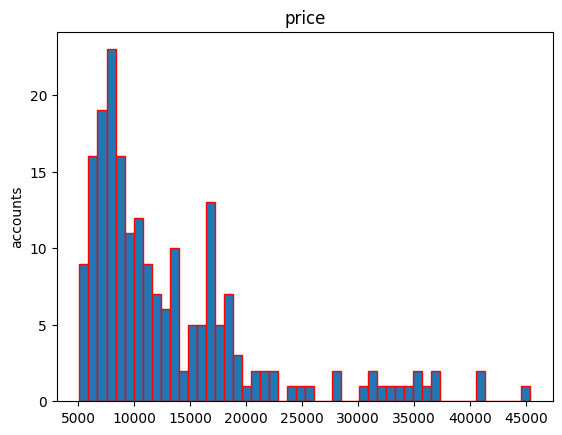

In [ ]:
# 特征工程——因变量price
car_price = train.loc[:,'price']

plt.hist(car_price,bins=50,edgecolor="r")
plt.title("price")
# plt.xlabel("accounts")
plt.ylabel("accounts")

plt.show()

**观察到数据分布左偏，不符合正态分布的良好性质；考虑取对数**

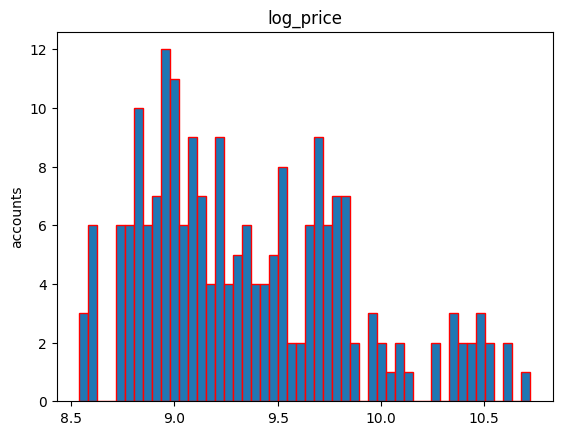

In [ ]:
# 数据正态化处理
log_car_price = np.log1p(car_price)

plt.hist(log_car_price,bins=50,edgecolor="r")
plt.title("log_price")
# plt.xlabel("accounts")
plt.ylabel("accounts")

plt.show()

In [ ]:
# 其他自变量正态化
all_data = train.copy()
#log transform skewed numeric features:
#找出df中数值型的变量
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
#compute skewness
#计算偏度，找出df中数值型变量中，偏度大于0.75这个阈值的特征
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
#对偏度较大的特征数据进行Log1p()转换。
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

**去除无关变量,从原始的26类中保留相关度高的18类特征。注意这里我没有进行类型的重分或者拆解,直接去除了carname**

In [ ]:
new_data = all_data[['fueltype','aspiration','doornumber','carbody','drivewheel','enginetype','cylindernumber','fuelsystem'
             ,'wheelbase','carlength','carwidth','curbweight','enginesize','boreratio','horsepower','citympg','highwaympg',
             'price']]

**定类数据独热编码，增添哑变量**

In [ ]:
new_data = pd.get_dummies(new_data, columns=["fueltype","aspiration","doornumber","carbody","drivewheel","enginetype","cylindernumber","fuelsystem"])

new_data.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,price,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,4.495355,168.8,4.175925,2548,4.875197,3.47,4.718499,21,27,9.510149,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,4.495355,168.8,4.175925,2548,4.875197,3.47,4.718499,21,27,9.711176,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,4.559126,171.2,4.197202,2823,5.030438,2.68,5.043425,19,26,9.711176,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,4.613138,176.6,4.207673,2337,4.700480,3.19,4.634729,24,30,9.543306,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,4.609162,176.6,4.210645,2824,4.919981,3.19,4.753590,18,22,9.767152,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


# **数据标准化**

In [ ]:
scaler = StandardScaler()
col_names = ['wheelbase','carlength','carwidth','curbweight','enginesize','boreratio','horsepower','citympg','highwaympg']

new_data[col_names] = scaler.fit_transform(new_data[col_names])

**处理后数据预览**

In [ ]:
new_data.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,price,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,-1.801353,-0.426521,-0.851698,-0.014566,0.237430,0.519071,0.365318,-0.646553,-0.546059,9.510149,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,-1.801353,-0.426521,-0.851698,-0.014566,0.237430,0.519071,0.365318,-0.646553,-0.546059,9.711176,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,-0.713827,-0.231513,-0.177732,0.514882,0.791580,-2.404880,1.319046,-0.953012,-0.691627,9.711176,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0.207276,0.207256,0.153949,-0.420797,-0.386244,-0.517266,0.119435,-0.186865,-0.109354,9.543306,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.139468,0.207256,0.248080,0.516807,0.397290,-0.517266,0.468318,-1.106241,-1.273900,9.767152,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


**按照训练集和测试集4:1的比例进行数据集划分**

In [ ]:
X = new_data.drop(columns=["price"])
y = new_data["price"]
type(X)

pandas.core.frame.DataFrame

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# 将数据类型转换为torch.tensor
features, labels = torch.tensor(x_train.values,dtype=torch.float32), torch.tensor(y_train.values,dtype=torch.float32)
test_features, test_labels = torch.tensor(x_test.values,dtype=torch.float32), torch.tensor(y_test.values,dtype=torch.float32)
features.shape, labels.shape, test_features.shape, test_labels.shape

(torch.Size([164, 45]),
 torch.Size([164]),
 torch.Size([41, 45]),
 torch.Size([41]))

使用Pytorch实现线性回归


In [ ]:
import torch.utils.data as Data

batch_size = 30
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)


模型定义

In [ ]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(features.shape[1])
print(net) # 打印网络的结构

LinearNet(
  (linear): Linear(in_features=45, out_features=1, bias=True)
)


模型训练

In [ ]:
optimizers = {} # 测试不同优化算法

训练集上得分: MSE=0.0627, R2=74.69
测试集上得分: MSE=0.1731, R2=36.18


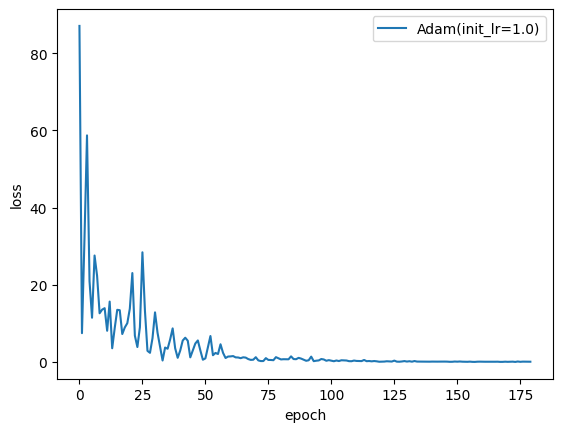

In [ ]:
loss = nn.MSELoss() # 损失函数

optimizer = torch.optim.SGD(net.parameters(), lr=0.01) # 优化器
#optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # 优化器
#optimizer = torch.optim.Adagrad(net.parameters(), lr=0.01) # 优化器
#optimizer = torch.optim.RMSprop(net.parameters(), lr=0.1) # 优化器
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1) # 优化器

# 固定随机种子
seed=42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# 初始化参数
nn.init.normal_(net.linear.weight, mean=0, std=0.01) # 将weight按照正态分布随机初始化
nn.init.constant_(net.linear.bias, val=0) # 将bias初始化为0

# 训练
loss_buf = []
num_epochs = 30

for epoch in range(num_epochs):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        loss_buf.append(l.item())

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    # print('epoch %d, loss: %f' % (epoch+1, l.item())

# 测试
train_pred = net(features)
test_pred = net(test_features)

mse_train_score = mean_squared_error(labels.detach().numpy(),train_pred.detach().numpy())
mse_test_score = mean_squared_error(test_labels.detach().numpy(),test_pred.detach().numpy())
r2_train_score = r2_score(labels.detach().numpy(),train_pred.detach().numpy())*100
r2_test_score = r2_score(test_labels.detach().numpy(),test_pred.detach().numpy())*100
print(f"训练集上得分: MSE={mse_train_score:.4f}, R2={r2_train_score:.2f}")
print(f"测试集上得分: MSE={mse_test_score:.4f}, R2={r2_test_score:.2f}")

optimizers['Adam'] = loss_buf[:]

import matplotlib.pyplot as plt

#折线图
x = list(range(len(loss_buf)))
plt.plot(x,loss_buf, label="Adam(init_lr=1.0)")
plt.legend(loc="best")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [ ]:
print(optimizers.keys())

dict_keys(['sgd', 'momentum', 'Adagrad', 'RMSprop', 'Adam'])


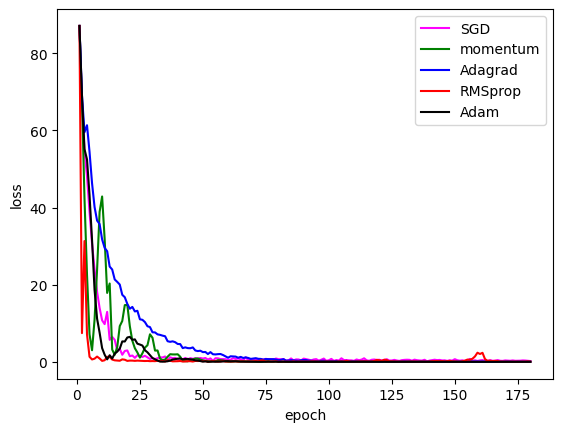

In [ ]:
# 绘制不同优化算法的loss曲线
start = 0
plt.plot(list(range(start+1, len(optimizers['sgd'])+1)),optimizers['sgd'],label="SGD",color='magenta')
plt.plot(list(range(start+1, len(optimizers['sgd'])+1)),optimizers['momentum'][start:],label="momentum",color='green')
plt.plot(list(range(start+1, len(optimizers['sgd'])+1)),optimizers['Adagrad'][start:],label="Adagrad",color='blue')
plt.plot(list(range(start+1, len(optimizers['sgd'])+1)),optimizers['RMSprop'][start:],label="RMSprop",color='red')
plt.plot(list(range(start+1, len(optimizers['sgd'])+1)),optimizers['Adam'][start:],label="Adam",color='black')
#plt.plot(np.linspace(0.0,5.0,51),mse2[1],label="Lasso test",color='orange')
#plt.plot(np.linspace(0.0,5.0,51),mse1[2],label="Ridge train",color='cyan',linestyle='--',alpha=0.8)
#plt.plot(np.linspace(0.0,5.0,51),mse2[2],label="Ridge test",color='cyan')
plt.legend(loc="best")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

模型评价

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

train_pred = net(features)
test_pred = net(test_features)

mse_train_score = mean_squared_error(labels.detach().numpy(),train_pred.detach().numpy())
mse_test_score = mean_squared_error(test_labels.detach().numpy(),test_pred.detach().numpy())
r2_train_score = r2_score(labels.detach().numpy(),train_pred.detach().numpy())*100
r2_test_score = r2_score(test_labels.detach().numpy(),test_pred.detach().numpy())*100
print(f"训练集上得分: MSE={mse_train_score:.4f}, R2={r2_train_score:.2f}")
print(f"测试集上得分: MSE={mse_test_score:.4f}, R2={r2_test_score:.2f}")

训练集上得分: MSE=0.0198, R2=92.00
测试集上得分: MSE=0.0656, R2=75.82


In [ ]:
def train_func(lr, num_epochs):

  seed=42

  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  loss = nn.MSELoss() # 损失函数

  optimizer = torch.optim.SGD(net.parameters(), lr=lr) # 优化器

  # 初始化参数
  nn.init.normal_(net.linear.weight, mean=0, std=0.01) # 将weight按照正态分布随机初始化
  nn.init.constant_(net.linear.bias, val=0) # 将bias初始化为0

  # 训练
  loss_buf = []
  num_epochs = num_epochs
  for epoch in range(num_epochs):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        loss_buf.append(l.item())

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    # print('epoch %d, loss: %f' % (epoch+1, l.item())

  # 测试
  train_pred = net(features)
  test_pred = net(test_features)

  mse_train_score = mean_squared_error(labels.detach().numpy(),train_pred.detach().numpy())
  mse_test_score = mean_squared_error(test_labels.detach().numpy(),test_pred.detach().numpy())
  r2_train_score = r2_score(labels.detach().numpy(),train_pred.detach().numpy())*100
  r2_test_score = r2_score(test_labels.detach().numpy(),test_pred.detach().numpy())*100
  print(f"训练集上得分: MSE={mse_train_score:.4f}, R2={r2_train_score:.2f}")
  print(f"测试集上得分: MSE={mse_test_score:.4f}, R2={r2_test_score:.2f}")
  return loss_buf #mse_train_score, r2_train_score, mse_test_score, r2_test_score

In [ ]:
# 探究学习率对模型训练的影响
num_epochs = 51
losses = {}
for lr in [0.0001, 0.001, 0.01, 0.1, 0.15]:
  losses[lr] = train_func(lr, num_epochs)

训练集上得分: MSE=63.5461, R2=-25538.53
测试集上得分: MSE=64.1043, R2=-23529.90
训练集上得分: MSE=4.2695, R2=-1622.60
测试集上得分: MSE=5.3772, R2=-1882.12
训练集上得分: MSE=0.3814, R2=-53.86
测试集上得分: MSE=0.7902, R2=-191.29
训练集上得分: MSE=0.0347, R2=85.99
测试集上得分: MSE=0.1262, R2=53.48
训练集上得分: MSE=1.7471, R2=-604.89
测试集上得分: MSE=1.9808, R2=-630.15


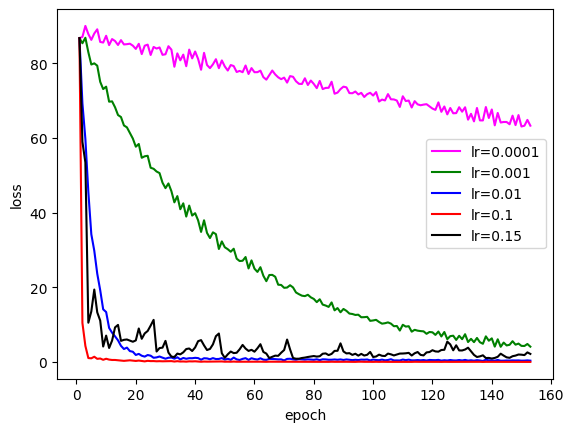

In [ ]:
# 绘制不同学习率的loss曲线
start = 0
plt.plot(list(range(start+1, len(losses[0.01])+1)),losses[0.0001],label="lr=0.0001",color='magenta')
plt.plot(list(range(start+1, len(losses[0.01])+1)),losses[0.001][start:],label="lr=0.001",color='green')
plt.plot(list(range(start+1, len(losses[0.01])+1)),losses[0.01][start:],label="lr=0.01",color='blue')
plt.plot(list(range(start+1, len(losses[0.01])+1)),losses[0.1][start:],label="lr=0.1",color='red')
plt.plot(list(range(start+1, len(losses[0.01])+1)),losses[0.1506][start:],label="lr=0.15",color='black')
#plt.plot(np.linspace(0.0,5.0,51),mse2[1],label="Lasso test",color='orange')
#plt.plot(np.linspace(0.0,5.0,51),mse1[2],label="Ridge train",color='cyan',linestyle='--',alpha=0.8)
#plt.plot(np.linspace(0.0,5.0,51),mse2[2],label="Ridge test",color='cyan')
plt.legend(loc="best")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()